In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
X_train = pd.read_csv('../datasets/scaled_train_test/X_train_standard.csv', delimiter=',')
X_test = pd.read_csv('../datasets/scaled_train_test/X_test_standard.csv', delimiter=',')
y_train = X_train['Value (kWh)']
y_test = X_test['Value (kWh)']
X_train.drop(['Value (kWh)'], axis=1, inplace=True)
X_test.drop(['Value (kWh)'], axis=1, inplace=True)

In [73]:
X_test.columns

Index(['Pressure (msl) (hPa)', 'Relative humidity (%)',
       'Air temperature (degC)', 'Dew-point temperature (degC)',
       'Wind speed (m/s)', 'Global radiation (W/m2)', 'Wind_direction',
       'Cloud_amount_binary', 'Precipitation_binary', 'hour_of_day',
       'day_of_year', 'solar_elev_angle', 'sun_azimuth'],
      dtype='object')

In [3]:
import tensorflow as tf
keras = tf.keras
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

We will split the X_train data further into X_train and X_val, which is going to be our validation set.

In [27]:
from sklearn.model_selection import train_test_split

In [58]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [37]:
X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.8) 

In [39]:
nn = keras.models.Sequential()
nn.add(keras.layers.Dense(300, activation='relu', input_shape=X_train_v.shape[1:]))
nn.add(keras.layers.Dense(200, activation='relu'))
nn.add(keras.layers.Dense(100, activation='relu'))
nn.add(keras.layers.Dense(1))
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
nn.compile(optimizer=optimizer, loss='mean_squared_error')

In [40]:
history = nn.fit(X_train_v,y_train_v, epochs=100,
                 validation_data=(X_val,y_val),
                callbacks=[lr_schedule, reset_states])

Epoch 1/100
212/212 [==============================] - 1s 5ms/step - loss: 1.1270 - val_loss: 1.1204 - lr: 1.0000e-08
Epoch 2/100
212/212 [==============================] - 1s 4ms/step - loss: 1.1269 - val_loss: 1.1203 - lr: 1.1220e-08
Epoch 3/100
212/212 [==============================] - 1s 4ms/step - loss: 1.1268 - val_loss: 1.1202 - lr: 1.2589e-08
Epoch 4/100
212/212 [==============================] - 1s 4ms/step - loss: 1.1267 - val_loss: 1.1201 - lr: 1.4125e-08
Epoch 5/100
212/212 [==============================] - 1s 4ms/step - loss: 1.1266 - val_loss: 1.1200 - lr: 1.5849e-08
Epoch 6/100
212/212 [==============================] - 1s 5ms/step - loss: 1.1265 - val_loss: 1.1199 - lr: 1.7783e-08
Epoch 7/100
212/212 [==============================] - 1s 4ms/step - loss: 1.1264 - val_loss: 1.1197 - lr: 1.9953e-08
Epoch 8/100
212/212 [==============================] - 1s 5ms/step - loss: 1.1262 - val_loss: 1.1195 - lr: 2.2387e-08
Epoch 9/100
212/212 [==============================] - 1

Epoch 70/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1532 - val_loss: 0.1478 - lr: 2.8184e-05
Epoch 71/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1395 - val_loss: 0.1360 - lr: 3.1623e-05
Epoch 72/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1304 - val_loss: 0.1281 - lr: 3.5481e-05
Epoch 73/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1241 - val_loss: 0.1222 - lr: 3.9811e-05
Epoch 74/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1192 - val_loss: 0.1176 - lr: 4.4668e-05
Epoch 75/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1152 - val_loss: 0.1138 - lr: 5.0119e-05
Epoch 76/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1120 - val_loss: 0.1107 - lr: 5.6234e-05
Epoch 77/100
212/212 [==============================] - 1s 4ms/step - loss: 0.1093 - val_loss: 0.1081 - lr: 6.3096e-05
Epoch 78/100
212/212 [==========================

Read the proper learning rate, typically at the elbow of the graph.

(1e-08, 0.001, 0.0, 2.0)

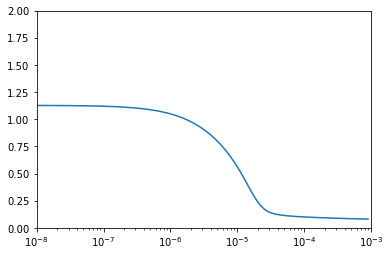

In [41]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0,2])

Selected learning rate: __1e-5__

#### Training NN model
The model will be training for maximum 500 epochs, saving itself each time it improves in __'my_checkpoint.h5'__. If there is no more improvement for the next 50 epochs, the __EarlyStopping__ callback will finish the training and use the checkpointed best model. 

In [42]:
nn = keras.models.Sequential()
nn.add(keras.layers.Dense(300, activation='relu', input_shape=X_train_v.shape[1:]))
nn.add(keras.layers.Dense(200, activation='relu'))
nn.add(keras.layers.Dense(100, activation='relu'))
nn.add(keras.layers.Dense(1))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
nn.compile(optimizer=optimizer, loss='mean_squared_error')
nn.fit(X_train_v,y_train_v, epochs=500, steps_per_epoch=200,
                                          validation_data=(X_val,y_val),
                                          validation_steps=50, callbacks=[early_stopping, model_checkpoint, reset_states])


Epoch 1/500
200/200 [==============================] - 0s 2ms/step - loss: 0.9460 - val_loss: 0.9010
Epoch 2/500
200/200 [==============================] - 0s 2ms/step - loss: 0.8587 - val_loss: 0.8169
Epoch 3/500
200/200 [==============================] - 0s 2ms/step - loss: 0.7767 - val_loss: 0.7380
Epoch 4/500
200/200 [==============================] - 0s 2ms/step - loss: 0.6988 - val_loss: 0.6641
Epoch 5/500
200/200 [==============================] - 0s 2ms/step - loss: 0.6279 - val_loss: 0.5946
Epoch 6/500
200/200 [==============================] - 0s 2ms/step - loss: 0.5581 - val_loss: 0.5309
Epoch 7/500
200/200 [==============================] - 0s 2ms/step - loss: 0.4903 - val_loss: 0.4729
Epoch 8/500
200/200 [==============================] - 0s 2ms/step - loss: 0.4423 - val_loss: 0.4213
Epoch 9/500
200/200 [==============================] - 0s 2ms/step - loss: 0.3977 - val_loss: 0.3760
Epoch 10/500
200/200 [==============================] - 0s 2ms/step - loss: 0.3474 - val_lo

200/200 [==============================] - 0s 2ms/step - loss: 0.1092 - val_loss: 0.1072
Epoch 82/500
200/200 [==============================] - 1s 3ms/step - loss: 0.1022 - val_loss: 0.1070
Epoch 83/500
200/200 [==============================] - 1s 3ms/step - loss: 0.1086 - val_loss: 0.1068
Epoch 84/500
200/200 [==============================] - 0s 2ms/step - loss: 0.1087 - val_loss: 0.1066
Epoch 85/500
200/200 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1064
Epoch 86/500
200/200 [==============================] - 0s 2ms/step - loss: 0.1072 - val_loss: 0.1062
Epoch 87/500
200/200 [==============================] - 1s 3ms/step - loss: 0.1033 - val_loss: 0.1060
Epoch 88/500
200/200 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1059
Epoch 89/500
200/200 [==============================] - 0s 2ms/step - loss: 0.1076 - val_loss: 0.1057
Epoch 90/500
200/200 [==============================] - 1s 3ms/step - loss: 0.1039 - val_loss: 

Epoch 161/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0977 - val_loss: 0.0976
Epoch 162/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0954 - val_loss: 0.0975
Epoch 163/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0988 - val_loss: 0.0974
Epoch 164/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0957 - val_loss: 0.0974
Epoch 165/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0986 - val_loss: 0.0973
Epoch 166/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0972
Epoch 167/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0993 - val_loss: 0.0971
Epoch 168/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0930 - val_loss: 0.0971
Epoch 169/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.0970
Epoch 170/500
200/200 [==============================] - 0s 2ms/step - lo

200/200 [==============================] - 0s 2ms/step - loss: 0.0937 - val_loss: 0.0932
Epoch 241/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0897 - val_loss: 0.0931
Epoch 242/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0948 - val_loss: 0.0931
Epoch 243/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.0930
Epoch 244/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.0930
Epoch 245/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0915 - val_loss: 0.0930
Epoch 246/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0885 - val_loss: 0.0929
Epoch 247/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0929
Epoch 248/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0931 - val_loss: 0.0928
Epoch 249/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0925 - v

200/200 [==============================] - 0s 2ms/step - loss: 0.0902 - val_loss: 0.0906
Epoch 320/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0905
Epoch 321/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0905
Epoch 322/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0846 - val_loss: 0.0905
Epoch 323/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0868 - val_loss: 0.0904
Epoch 324/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0904
Epoch 325/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0904
Epoch 326/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0886 - val_loss: 0.0904
Epoch 327/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0904
Epoch 328/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0899 - v

200/200 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0888
Epoch 399/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0888
Epoch 400/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0888
Epoch 401/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0858 - val_loss: 0.0887
Epoch 402/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0874 - val_loss: 0.0887
Epoch 403/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.0887
Epoch 404/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0887
Epoch 405/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0855 - val_loss: 0.0887
Epoch 406/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0879 - val_loss: 0.0886
Epoch 407/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0851 - v

200/200 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.0875
Epoch 478/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0875
Epoch 479/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.0875
Epoch 480/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0856 - val_loss: 0.0874
Epoch 481/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0855 - val_loss: 0.0874
Epoch 482/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0874
Epoch 483/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 484/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0874
Epoch 485/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0874
Epoch 486/500
200/200 [==============================] - 0s 2ms/step - loss: 0.0776 - v

In [43]:
model = keras.models.load_model("my_checkpoint.h5")

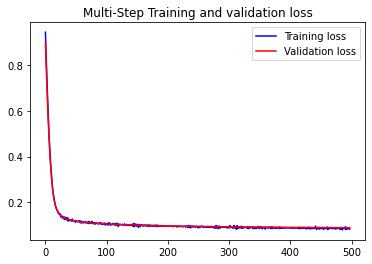

In [64]:
plot_train_history(nn.history, 'Multi-Step Training and validation loss')

### Validation set

In [44]:
#predicting on the train set
y_pred = model.predict(X_train_v)
print('train mse: {}'.format(mean_squared_error(y_train_v, y_pred)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train_v, y_pred))))
print('train r2: {}'.format(r2_score(y_train_v, y_pred)))
print()

#predicting on the test set
y_pred = model.predict(X_val)

# determine mse and rmse
print('test mse: {}'.format(mean_squared_error(y_val, y_pred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_val, y_pred))))
print('test r2: {}'.format(r2_score(y_val, y_pred)))

train mse: 0.08406488901888014
train rmse: 0.2899394575060113
train r2: 0.9162347314658573

test mse: 0.08721458573679514
test rmse: 0.29532115694070266
test r2: 0.9127063624209044


Text(0.5, 1.0, 'Evaluation of Neural Network Predictions')

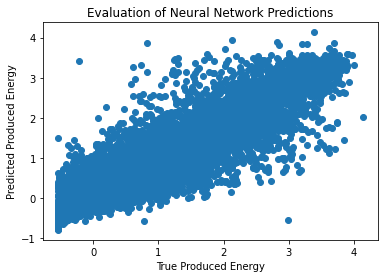

In [45]:
plt.scatter(y_val, model.predict(X_val))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Neural Network Predictions')

Text(0.5, 1.0, 'Error distribution')

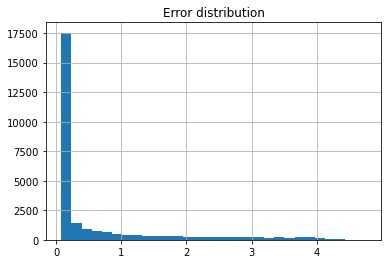

In [46]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_val - model.predict(X_val)[0]
errors.hist(bins=30)
plt.title('Error distribution')

#### Test data

In [48]:
#predicting on the train set
y_pred = model.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_test, y_pred)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_test, y_pred))))
print('train r2: {}'.format(r2_score(y_test, y_pred)))
print()

#predicting on the test set
y_pred = model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format(mean_squared_error(y_test, y_pred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, y_pred))))
print('test r2: {}'.format(r2_score(y_test, y_pred)))

train mse: 0.08888485253271736
train rmse: 0.29813562774803914
train r2: 0.9098947326605751

test mse: 0.08888485253271736
test rmse: 0.29813562774803914
test r2: 0.9098947326605751


Text(0.5, 1.0, 'Evaluation of Neural Network Predictions')

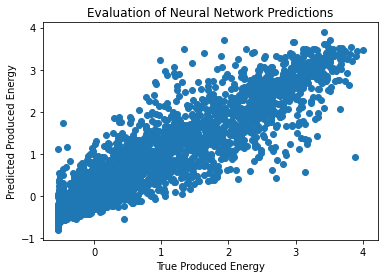

In [49]:
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Neural Network Predictions')

Text(0.5, 1.0, 'Error distribution')

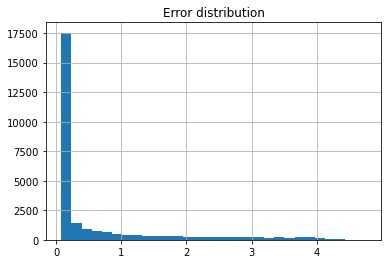

In [50]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_val - model.predict(X_val)[0]
errors.hist(bins=30)
plt.title('Error distribution')

## Hyperparameter tuning for Neural Networks with Keras and Scikit-learn
Neural networks are very flexible in terms of their architecture, which is, consequently, one of their drawbacks. There are just numerous combinations of hyperparameters to tweak and choose from. Even in simple Multi Layer Perceptron (MLP) that we used, one can change the number of layers, the number of neurons per layer, types of activation functions, etc.

We will create a function which would sum up our model and use a keras scikit-learn wrapper to 'wrap' the model as if it is a scikit-learn regressor which we can later use with RandomizedSearchCV.

In [87]:
def build_model(n_hidden,n_neurons, learning_rate=1e-5,input_shape=[13]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [88]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

In [92]:
param_dist = {
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(1,300,50)
}

In [ ]:
nn_search_cv = RandomizedSearchCV(keras_reg, param_dist, n_iter=10, cv=3)
nn_search_cv.fit(X_train_v,y_train_v, epochs=100,
                 validation_data=(X_val,y_val),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 2.8696 - val_loss: 2.8832
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 2.8359 - val_loss: 2.8497
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 2.8027 - val_loss: 2.8168
Epoch 4/100
141/141 [==============================] - 1s 4ms/step - loss: 2.7700 - val_loss: 2.7843
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 2.7378 - val_loss: 2.7522
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 2.7060 - val_loss: 2.7207
Epoch 7/100
141/141 [==============================] - 1s 4ms/step - loss: 2.6747 - val_loss: 2.6895
Epoch 8/100
141/141 [==============================] - 1s 4ms/step - loss: 2.6438 - val_loss: 2.6588
Epoch 9/100
141/141 [==============================] - 1s 4ms/step - loss: 2.6133 - val_loss: 2.6285
Epoch 10/100
141/141 [==============================] - 1s 4ms/step - loss: 2.5833 - val_lo

141/141 [==============================] - 1s 4ms/step - loss: 1.2349 - val_loss: 1.2522
Epoch 82/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2236 - val_loss: 1.2408
Epoch 83/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2124 - val_loss: 1.2296
Epoch 84/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2014 - val_loss: 1.2185
Epoch 85/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1905 - val_loss: 1.2075
Epoch 86/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1798 - val_loss: 1.1967
Epoch 87/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1692 - val_loss: 1.1861
Epoch 88/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1587 - val_loss: 1.1755
Epoch 89/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1483 - val_loss: 1.1651
Epoch 90/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1381 - val_loss: 

Epoch 61/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0016 - val_loss: 1.0002
Epoch 62/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9940 - val_loss: 0.9928
Epoch 63/100
141/141 [==============================] - 1s 5ms/step - loss: 0.9865 - val_loss: 0.9855
Epoch 64/100
141/141 [==============================] - 1s 5ms/step - loss: 0.9790 - val_loss: 0.9783
Epoch 65/100
141/141 [==============================] - 1s 5ms/step - loss: 0.9717 - val_loss: 0.9712
Epoch 66/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9645 - val_loss: 0.9642
Epoch 67/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9574 - val_loss: 0.9573
Epoch 68/100
141/141 [==============================] - 1s 4ms/step - loss: 0.9503 - val_loss: 0.9504
Epoch 69/100
141/141 [==============================] - 1s 5ms/step - loss: 0.9434 - val_loss: 0.9437
Epoch 70/100
141/141 [==============================] - 1s 6ms/step - loss: 0.9366

141/141 [==============================] - 1s 4ms/step - loss: 1.2606 - val_loss: 1.2791
Epoch 41/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2526 - val_loss: 1.2712
Epoch 42/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2448 - val_loss: 1.2634
Epoch 43/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2370 - val_loss: 1.2556
Epoch 44/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2293 - val_loss: 1.2479
Epoch 45/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2217 - val_loss: 1.2403
Epoch 46/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2141 - val_loss: 1.2328
Epoch 47/100
141/141 [==============================] - 1s 4ms/step - loss: 1.2067 - val_loss: 1.2254
Epoch 48/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1993 - val_loss: 1.2180
Epoch 49/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1920 - val_loss: 

Epoch 20/100
141/141 [==============================] - 1s 6ms/step - loss: 1.1370 - val_loss: 1.1530
Epoch 21/100
141/141 [==============================] - 1s 6ms/step - loss: 1.1289 - val_loss: 1.1449
Epoch 22/100
141/141 [==============================] - 1s 6ms/step - loss: 1.1209 - val_loss: 1.1370
Epoch 23/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1131 - val_loss: 1.1291
Epoch 24/100
141/141 [==============================] - 1s 4ms/step - loss: 1.1054 - val_loss: 1.1214
Epoch 25/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0978 - val_loss: 1.1138
Epoch 26/100
141/141 [==============================] - 1s 6ms/step - loss: 1.0903 - val_loss: 1.1063
Epoch 27/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0829 - val_loss: 1.0990
Epoch 28/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0756 - val_loss: 1.0917
Epoch 29/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0685

In [ ]:
nn_search_cv.best_params_

In [ ]:
import pickle
nn_best_param = nn_search_cv.best_params_
pickle.dump(nn_best_param, open( "nn_best_param_CV.p", "wb" ) )

In [83]:
model = nn_search_cv.best_estimator_.model

In [84]:
#predicting on the train set
y_pred = model.predict(X_test)
print('train mse: {}'.format(mean_squared_error(y_test, y_pred)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_test, y_pred))))
print('train r2: {}'.format(r2_score(y_test, y_pred)))
print()

#predicting on the test set
y_pred = model.predict(X_test)

# determine mse and rmse
print('test mse: {}'.format(mean_squared_error(y_test, y_pred)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, y_pred))))
print('test r2: {}'.format(r2_score(y_test, y_pred)))

train mse: 0.35049997961014
train rmse: 0.592030387404346
train r2: 0.6446875540057879

test mse: 0.35049997961014
test rmse: 0.592030387404346
test r2: 0.6446875540057879


In [ ]:
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True Produced Energy')
plt.ylabel('Predicted Produced Energy')
plt.title('Evaluation of Neural Network Predictions')

In [ ]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test - model.predict(X_test)[0]
errors.hist(bins=30)
plt.title('Error distribution')